In [109]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [110]:
## Applied Statistics - Turma 9DTS
### Projeto Integrado Parte 2

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [111]:
# Importar a base de dados
data = pd.read_csv('/content/drive/MyDrive/FIAP/Estatistica Avançada/Applied Statistics Projeto Integrado 2/Base_ScoreCredito_QuantumFinance.csv', sep=';', decimal=',', encoding='utf-8')

In [118]:
data.head()

,id,idade,sexo,estado_civil,escola,Qte_dependentes,tempo_ultimoservico,trabalha,vl_salario_mil,reg_moradia,casa_propria,vl_imovel_em_mil,Qte_cartoes,Qte_carros,SCORE_CREDITO
3407,714600258,45,Masculino,casado,doutorado,2,34,Sim,96.466045,A,Sim,365,1,1,453.0
7288,771067308,38,Feminino,solteiro,graduacao,0,24,Sim,66.325176,A,Sim,562,1,0,329.4
7827,779034708,60,Feminino,casado,doutorado,0,38,Sim,112.023007,A,Sim,494,1,1,570.0
744,709606158,37,Feminino,casado,ensino medio,2,28,Sim,21.894759,A,Sim,488,1,1,531.0
4954,717657333,43,Feminino,solteiro,ensino medio,0,33,Sim,22.617145,A,Sim,478,1,1,488.7


### Preparação dos dados

In [112]:
"""
Tratamento dos dados
Função de remoção de outliers
"""
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

In [113]:
"""
Tratamento dos dados
Separação de tipos de dados
Aplicação de Hot-Encoding
Remoção de outliers
Train Test Split
"""

# Separar variáveis numéricas e categóricas
numeric_cols = ['idade', 'tempo_ultimoservico', 'vl_salario_mil', 'vl_imovel_em_mil', 'Qte_dependentes', 'Qte_cartoes', 'Qte_carros']
categorical_cols = ['sexo', 'estado_civil', 'escola', 'trabalha', 'reg_moradia', 'casa_propria']

# Mudar o formato da variável quantitativa em qualitativa
data['reg_moradia']= data['reg_moradia'].replace({1: 'A', 2: 'B',3: 'C',4: 'D',5: 'E',6: 'F'})
data['trabalha']= data['trabalha'].astype(str)
data['casa_propria']= data['casa_propria'].astype(str)

#Mudar preenchimento para colunas categoricas
data['sexo'] = data['sexo'].replace({'F': 'Feminino', 'M': 'Masculino'})
data['trabalha'] = data['trabalha'].replace({'0': 'Não', '1': 'Sim'})
data['casa_propria'] = data['casa_propria'].replace({'0': 'Não', '1': 'Sim'})

data = data.sort_values('reg_moradia',ascending=True)

#Remoção de outliers
for col in numeric_cols:
    data = remove_outliers(data, col)

#Selecionando apenas variáveis de interesse

data_insert = data[['SCORE_CREDITO','vl_salario_mil','vl_imovel_em_mil','estado_civil','escola','casa_propria']]

# Codificar variáveis categóricas usando One-Hot Encoding
encoder = OneHotEncoder()
encoded_categorical = encoder.fit_transform(data_insert.select_dtypes(object))
encoded_categorical = encoded_categorical.toarray()

# Concatenar variáveis numéricas e categóricas codificadas
X = np.concatenate([data_insert.select_dtypes(exclude=['object']).drop(columns=['SCORE_CREDITO']), encoded_categorical], axis=1)
y = data_insert['SCORE_CREDITO']

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Modelagem

In [114]:
"""
Modelo de regressão linear
"""
model = LinearRegression()

# Treinar o modelo
model.fit(X_train, y_train)

LinearRegression()

In [115]:
# Predições no conjunto de teste
y_pred = model.predict(X_test)

# Métricas de erro
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:',r2)

Mean Squared Error: 9064.962812573625
Root Mean Squared Error: 95.21009826995046
R-squared: 0.20514872663583528


### Analise dos resíduos

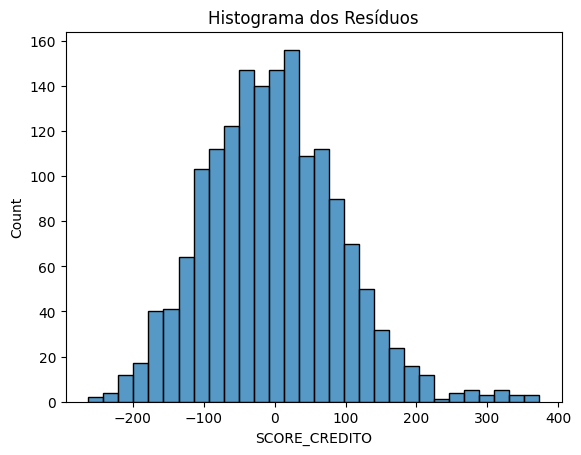

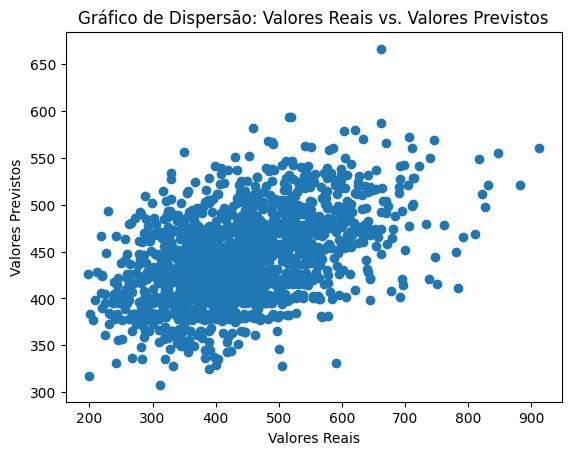

Shapiro-Wilk Test: 0.9891130860994992 9.134327733821083e-10


In [116]:
# Calcular os resíduos
residuals = y_test - y_pred

# Plotar um histograma dos resíduos
sns.histplot(residuals, bins=30)
plt.title('Histograma dos Resíduos')
plt.show()

# Plotar um gráfico de dispersão dos valores previstos vs. os valores reais
plt.scatter(y_test, y_pred)
plt.xlabel('Valores Reais')
plt.ylabel('Valores Previstos')
plt.title('Gráfico de Dispersão: Valores Reais vs. Valores Previstos')
plt.show()

# Teste de normalidade dos resíduos (opcional)
from scipy.stats import shapiro
stat, p = shapiro(residuals)
print('Shapiro-Wilk Test:', stat, p)

In [119]:

def prever_score_credito(vl_salario_mil, vl_imovel_em_mil, estado_civil, escola, casa_propria):
    """
    Função para prever o score de crédito com base nas entradas do usuário.

    Args:
        vl_salario_mil (float): Valor do salário em milhares.
        vl_imovel_em_mil (int): Valor do imóvel em milhares.
        estado_civil (str): Estado civil.
        escola (str): Nível de escolaridade.
        casa_propria (str): Possui casa própria (Sim ou Não).

    Returns:
        float: Previsão do score de crédito.
    """

    # Criar um DataFrame com os dados de entrada
    new_data = pd.DataFrame({
        'vl_salario_mil': [vl_salario_mil],
        'vl_imovel_em_mil': [vl_imovel_em_mil],
        'estado_civil': [estado_civil],
        'escola': [escola],
        'casa_propria': [casa_propria]
    })

    # Selecionar as colunas numéricas e categóricas
    numeric_cols = ['vl_salario_mil', 'vl_imovel_em_mil']
    categorical_cols = ['estado_civil', 'escola', 'casa_propria']

    # Codificar as variáveis categóricas usando o mesmo encoder do treinamento
    encoded_categorical = encoder.transform(new_data[categorical_cols])
    encoded_categorical = encoded_categorical.toarray()

    # Concatenar as variáveis numéricas e categóricas codificadas
    new_data_prepared = np.concatenate([new_data[numeric_cols], encoded_categorical], axis=1)

    # Realizar a predição
    predicted_score = model.predict(new_data_prepared)

    return predicted_score[0]

# Exemplo de uso:
resultado = prever_score_credito(5, 200, 'casado', 'graduacao', 'Sim')
print("Score de Crédito previsto:", resultado)

Score de Crédito previsto: 345.5577218109444
